# **Análisis Exploratorio de Datos (EDA)**

### **Librerias**

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson


## **Contextualización del Conjunto de Datos**

Los datos provienen de transacciones reales de comercio electrónico registradas por la empresa Vesta. El conjunto incluye una amplia variedad de características que abarcan desde información del dispositivo utilizado hasta detalles específicos del producto adquirido. El propósito central del estudio es optimizar la detección de transacciones fraudulentas a gran escala, con el fin de reducir las pérdidas económicas para miles de empresas y, al mismo tiempo, minimizar los falsos positivos que afectan a millones de usuarios.


| **Variable**            | **Descripción**                                                                 |
|-------------------------|---------------------------------------------------------------------------------|
| `TransactionDT`         | Intervalo de tiempo a partir de una fecha y hora de referencia                  |
| `TransactionAMT`        | Importe del pago de la transacción en USD                                      |
| `ProductCD`             | Código de producto, el producto de cada transacción                            |
| `card1` - `card6`       | Información de la tarjeta de pago: tipo, categoría, banco emisor, país, etc.   |
| `addr`                  | Dirección                                                                      |
| `dist`                  | Distancia                                                                       |
| `P_emaildomain`         | Dominio de correo electrónico del comprador                                     |
| `R_emaildomain`         | Dominio de correo electrónico del destinatario                                  |
| `C1` - `C14`            | Recuento de direcciones asociadas a la tarjeta de pago (codificado)             |
| `D1` - `D15`            | Intervalos de tiempo entre eventos o transacciones                              |
| `M1` - `M9`             | Coincidencias como nombre y dirección entre usuario y tarjeta                   |
| `Vxxx`                  | Variables derivadas por Vesta: recuento, clasificación, relaciones entre entidades |
| `DeviceType`            | Información codificada del tipo de dispositivo                                  |
| `DeviceInfo`            | Información codificada del software/dispositivo utilizado                       |
| `id_12` - `id_38`       | Identidad codificada del usuario, IP, ISP, Proxy, firma digital, etc.           |
| `isfraud`               | 	Variable objetivo del análisis. Toma el valor 1 si la transacción fue identificada como fraudulenta y 0 en caso contrario.           |


In [64]:
# Cargar el dataset
df = pd.read_csv("dataset_final.csv") 

In [65]:
# Ver dimensiones
print("Dimensiones del dataset:")
print(f"Filas: {df.shape[0]:,}")
print(f"Columnas: {df.shape[1]:,}")

Dimensiones del dataset:
Filas: 144,233
Columnas: 73


El conjunto de datos utilizado para el análisis corresponde a una fusión de las tablas originales `train_transaction.csv` y `train_identity.csv`, realizada mediante una unión tipo `LEFT JOIN` a través del identificador común `TransactionID`. Este procedimiento permitió consolidar en un solo archivo la información transaccional y de identidad digital de los usuarios, con el objetivo de disponer de un conjunto completo para las tareas de limpieza, exploración y modelado.

Inicialmente, el dataframe resultante de esta fusión contenía 144.233 registros y un total de 434 variables. No obstante, este volumen incluía una gran cantidad de columnas completamente vacías o con alta proporción de valores nulos. En consecuencia, se eliminaron todas aquellas variables que contenían el 100% de datos ausentes, así como aquellas que presentaban más del 50% de valores nulos, por considerarse que no aportaban información estadísticamente confiable.

Una vez depurado el conjunto en términos de completitud, se procedió a imputar los valores faltantes restantes. Para las variables numéricas, se aplicó una estrategia de imputación basada en K-Nearest Neighbors (`KNNImputer`), en dos fases según el porcentaje de valores ausentes. Las variables con mayor proporción de nulos se imputaron primero para evitar que su carencia influyera en la calidad de la segunda imputación. En cuanto a las variables categóricas, dado que los porcentajes de nulos eran inferiores al 2.5%, se optó por una imputación directa mediante la moda de cada variable.

Adicionalmente, se implementaron procedimientos de reducción de dimensionalidad, comenzando con la eliminación de variables con **alta multicolinealidad** mediante el cálculo del **Factor de Inflación de Varianza (VIF)**. Este proceso se aplicó de manera iterativa antes de la imputación, eliminando sucesivamente las variables con mayor VIF hasta garantizar que todas las variables numéricas restantes presentaran una relación lineal aceptable (VIF < 10). Posteriormente, se evaluó la dependencia entre variables categóricas usando la **prueba de chi-cuadrado de independencia**, eliminando aquellas que presentaban correlación estadísticamente significativa con otras variables, lo cual contribuía a la redundancia en el modelo.

Como resultado de este proceso exhaustivo, el conjunto final de datos quedó conformado por 73 variables, todas completas, sin multicolinealidad severa, sin redundancias categóricas, y aptas para su utilización en el análisis exploratorio y el posterior modelado predictivo. Este procesamiento se documenta con mayor detalle en el cuaderno `Limpieza.ipynb`, donde se ejecutaron y justificaron todas las decisiones tomadas en relación con la estructura del dataset.
Para más información sobre la depuración y preparación del conjunto de datos, consulte la sección de [Procesamiento de los datos](#procesamiento-de-los-datos).



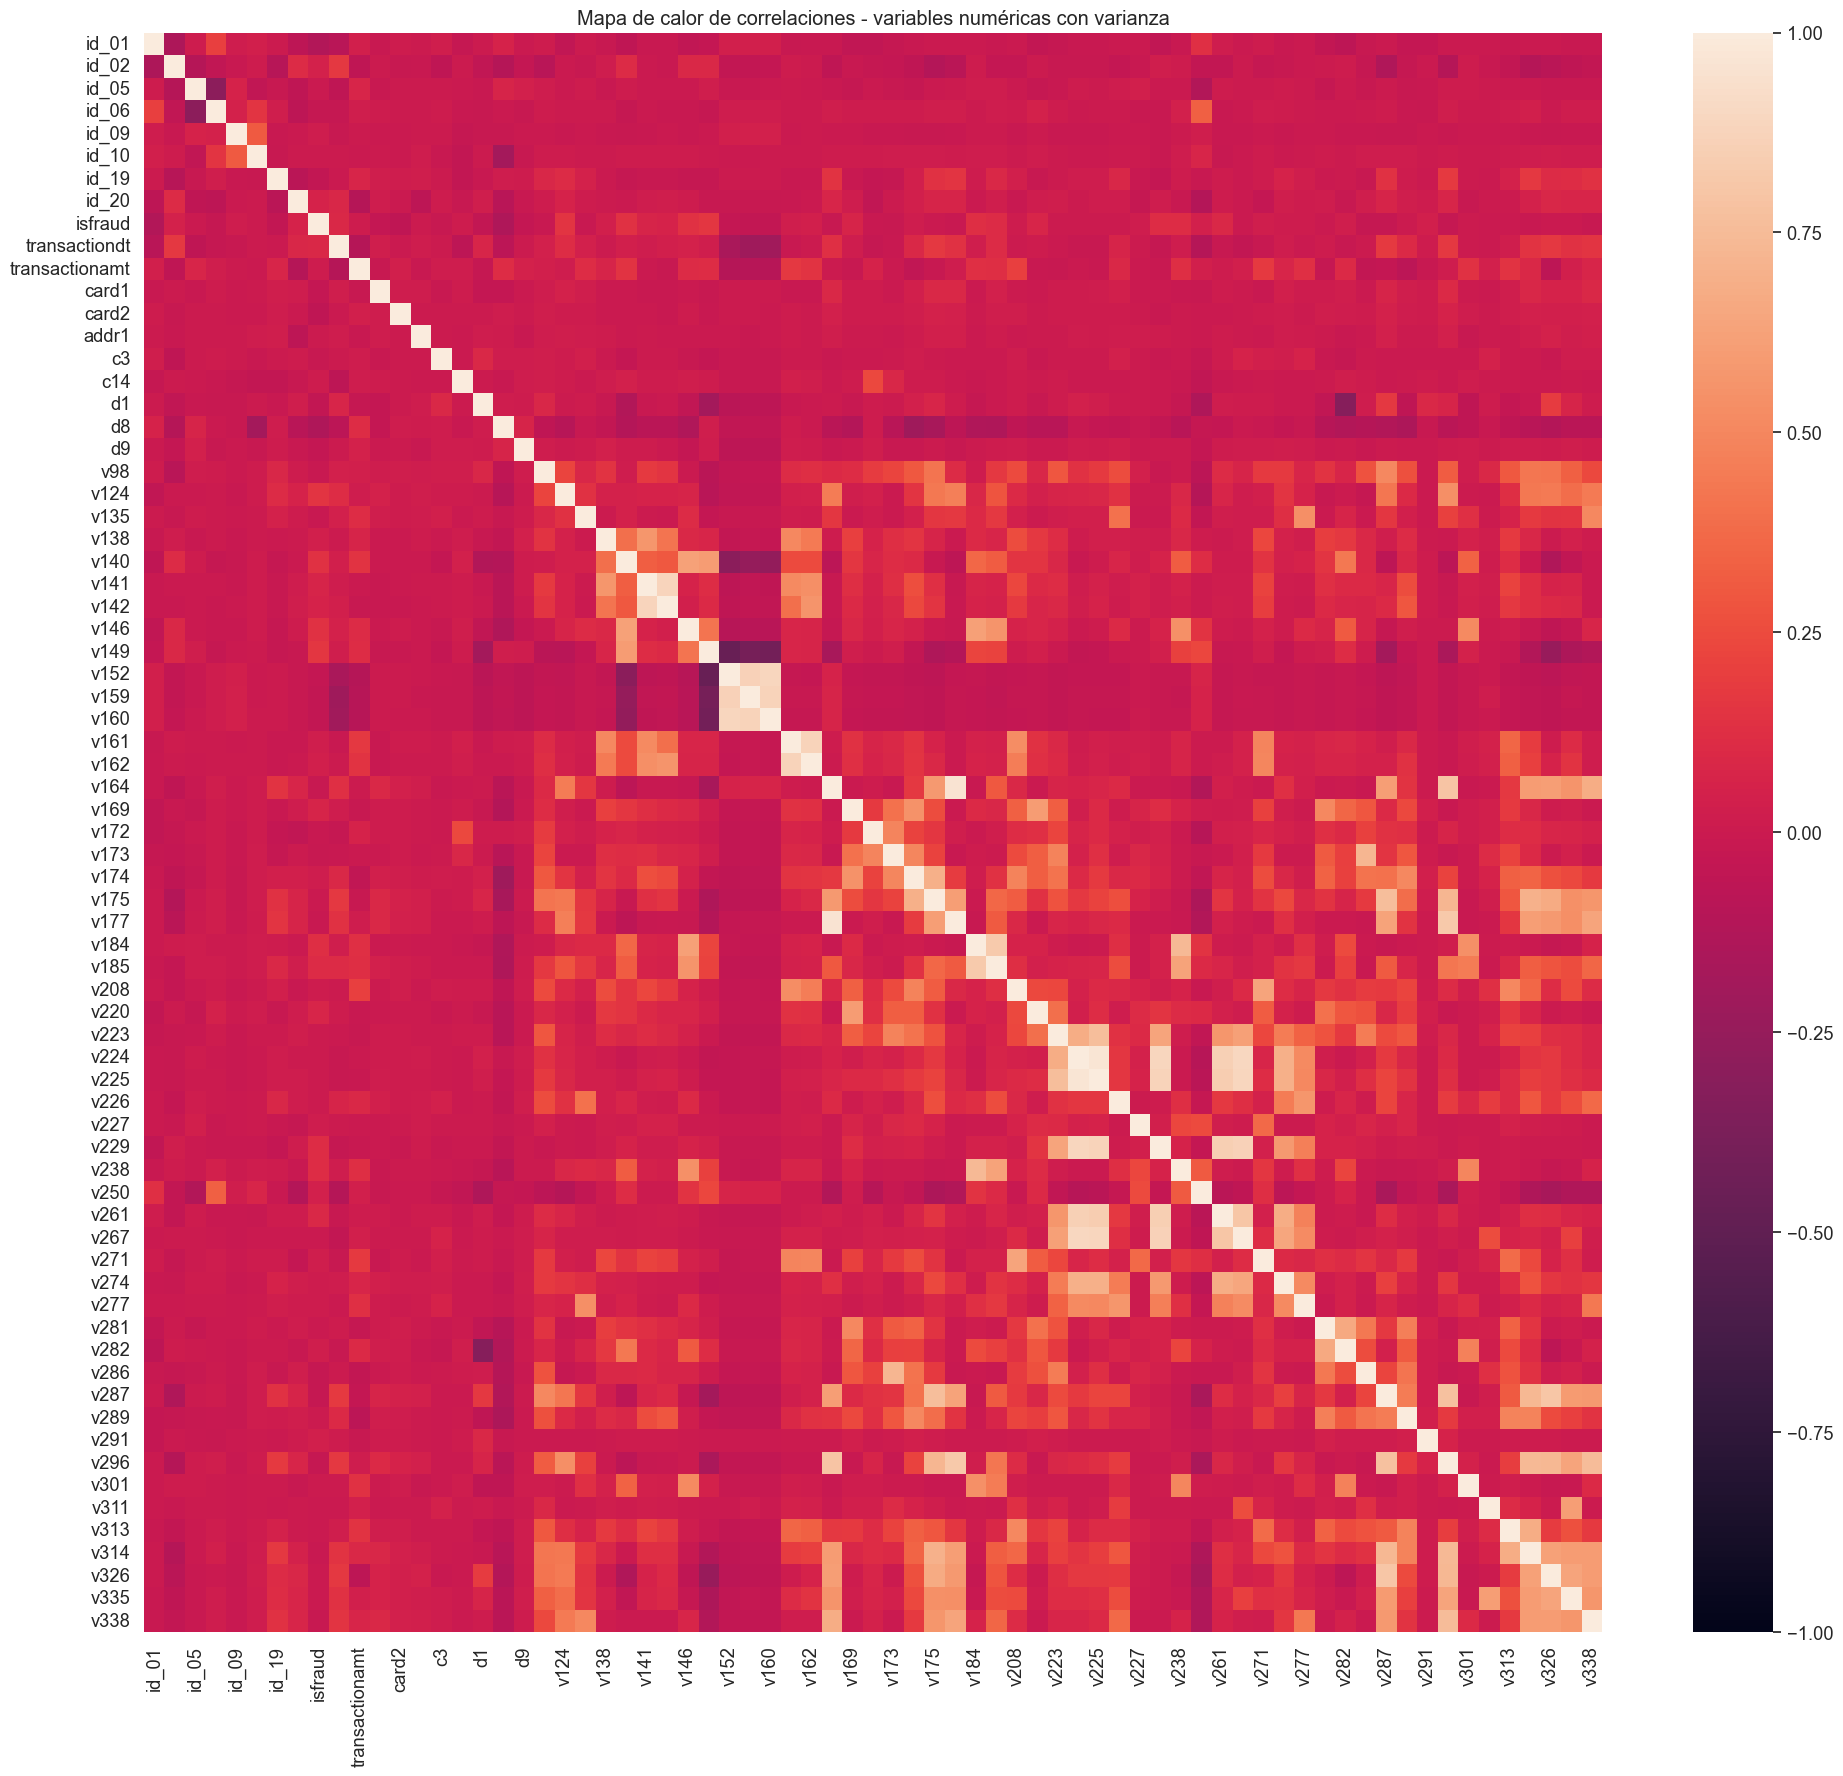


Correlaciones mayores a 0.5 en valor absoluto:

Variable 1 Variable 2  Correlación
      v224       v225     0.965967
      v164       v177     0.954704
      v224       v267     0.895364
      v152       v160     0.890158
      v225       v267     0.884584
      v224       v229     0.884220
      v141       v142     0.878163
      v225       v229     0.874259
      v161       v162     0.871518
      v159       v160     0.870647
      v229       v267     0.864629
      v152       v159     0.860561
      v224       v261     0.858885
      v229       v261     0.850337
      v225       v261     0.838475
      v184       v185     0.821148
      v177       v296     0.816557
      v261       v267     0.799711
      v287       v326     0.799032
      v164       v296     0.793871
      v287       v296     0.778452
      v175       v287     0.758639
      v223       v225     0.758616
      v296       v338     0.756296
      v296       v314     0.739028
      v184       v238     0.737623
      

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filtrar variables numéricas con al menos 2 valores distintos
num_cols = df.select_dtypes(include='number')
num_cols = num_cols.loc[:, num_cols.nunique() > 1]

# === Heatmap de correlaciones ===
plt.figure(figsize=(20, 18))
sns.heatmap(
    num_cols.corr(),
    cmap='rocket',
    vmin=-1,
    vmax=1,
    annot=False
)
plt.title("Mapa de calor de correlaciones - variables numéricas con varianza")
plt.tight_layout()
plt.show()

# === Mostrar correlaciones numéricas en modo texto (mayores a 0.5) ===
corr_matrix = num_cols.corr()
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']
corr_filtrada = corr_pairs[abs(corr_pairs['Correlación']) > 0.5] \
                    .sort_values(by='Correlación', key=lambda x: abs(x), ascending=False)

# Imprimir tabla de correlaciones significativas
print("\nCorrelaciones mayores a 0.5 en valor absoluto:\n")
print(corr_filtrada.to_string(index=False))



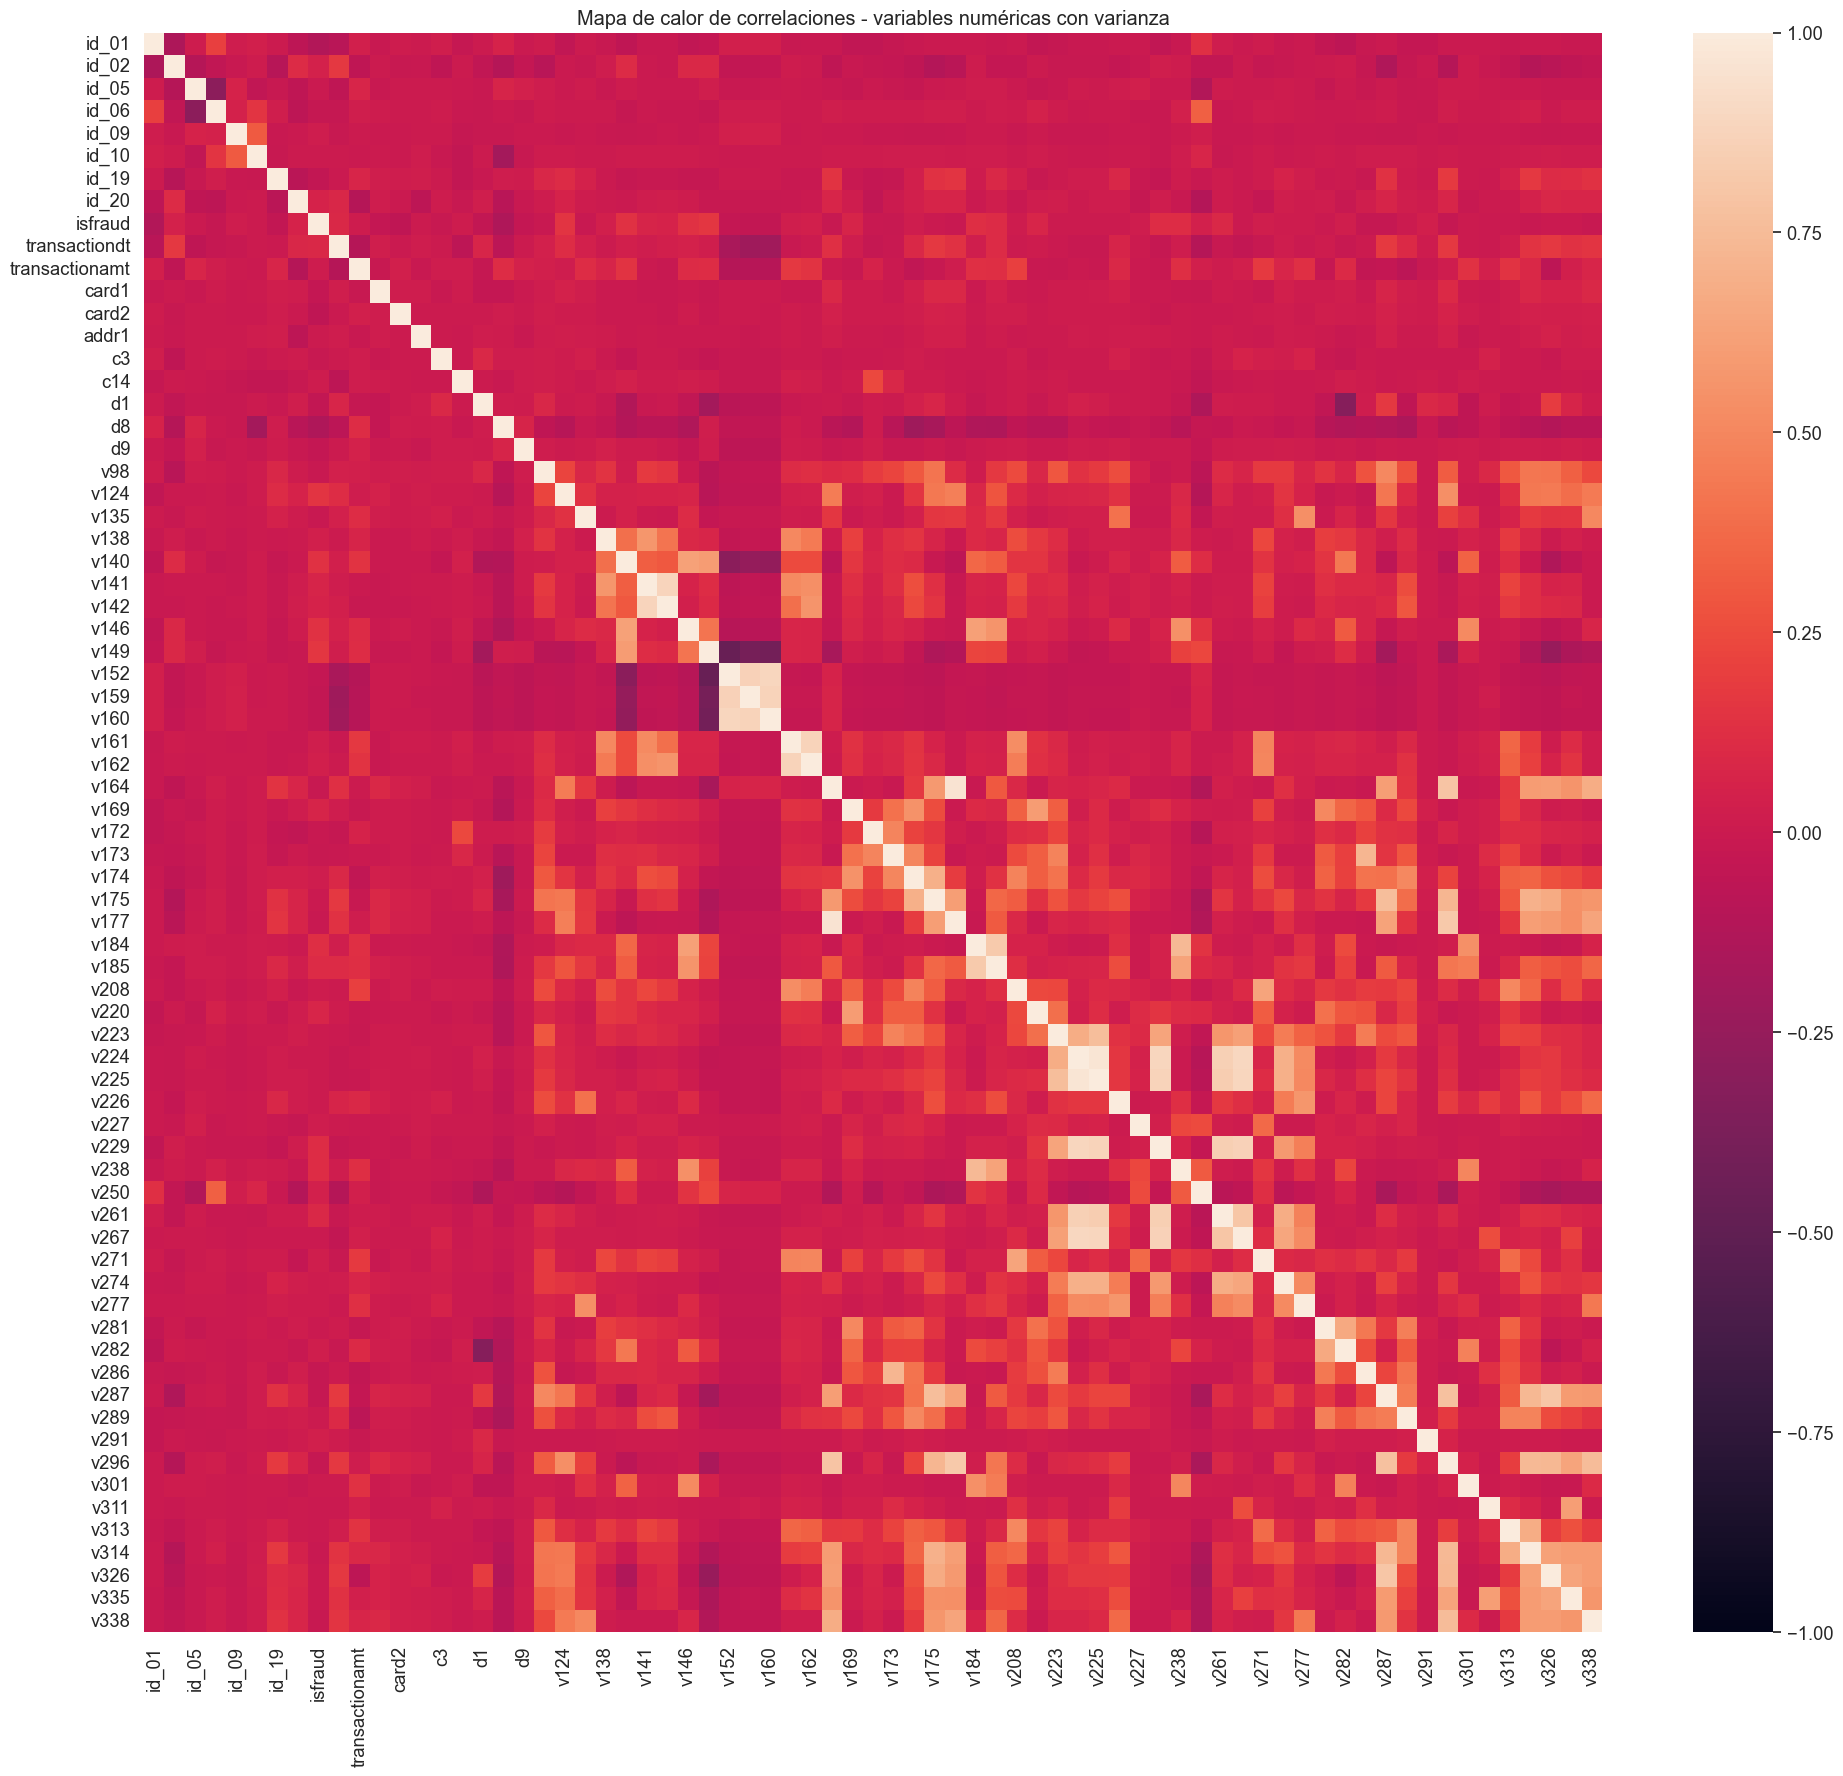

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar variables numéricas con al menos 2 valores distintos
num_cols = df.select_dtypes(include='number')
num_cols = num_cols.loc[:, num_cols.nunique() > 1]

# Correlación y heatmap
plt.figure(figsize=(20, 18))  # Ajusta tamaño según cantidad de columnas
sns.heatmap(
    num_cols.corr(),
    cmap='rocket',
    vmin=-1,
    vmax=1,
    annot=False
)
plt.title("Mapa de calor de correlaciones - variables numéricas con varianza")
plt.tight_layout()
plt.show()


Con el objetivo de verificar visualmente la eficacia del procedimiento de reducción de multicolinealidad, se presenta a continuación el mapa de calor de correlaciones entre todas las variables numéricas del dataset final que conservan varianza. Se observa que, tras la eliminación iterativa de variables con alto Factor de Inflación de Varianza (VIF), las correlaciones lineales entre las variables restantes son, en general, moderadas o bajas. Este resultado valida la consistencia del proceso de depuración, ya que no se identifican agrupaciones de variables con correlaciones cercanas a ±1, lo que garantiza una mayor estabilidad en los modelos de clasificación que se construirán posteriormente.



In [68]:
# Ver primeras filas
print("\nPrimeras filas del dataset:")
df.head()


Primeras filas del dataset:


,id_01,id_02,id_05,id_06,id_09,id_10,id_19,id_20,isfraud,transactiondt,...,v296,v301,v311,v313,v314,v326,v335,v338,id_38,card6
0,0.0,70787.0,0.0,0.0,0.000000,-2.800000,542.0,144.0,0.0,86506.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,T,credit
1,-5.0,98945.0,0.0,-5.0,0.000000,-0.400000,621.0,500.0,0.0,86535.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,T,debit
2,-5.0,191631.0,0.0,0.0,0.000000,0.000000,410.0,142.0,0.0,86549.0,...,1.0,1.0,31.841299,90.327904,90.327904,0.000000,0.000000,30.000000,T,credit
3,-5.0,221832.0,0.0,-6.0,0.091023,-0.301124,176.0,507.0,0.0,86555.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.851416,59.213495,151.546395,T,debit
4,0.0,7460.0,1.0,0.0,0.000000,0.000000,529.0,575.0,0.0,86620.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,T,debit


In [69]:
# Ver resumen de tipos de datos
print("Tipos de datos en el dataset")
print(df.dtypes.value_counts())

# Ver cantidad de valores nulos por columna (top 20)
print("\nValores nulos por columna")
nulls = df.isnull().sum().sort_values(ascending=False)
print(nulls[nulls > 0].head(20))


Tipos de datos en el dataset
float64    71
object      2
Name: count, dtype: int64

Valores nulos por columna
Series([], dtype: int64)


Luego de verificar visualmente las correlaciones entre las variables numéricas mediante el mapa de calor, se presenta a continuación un resumen estructural del dataset final. Se observa que el conjunto de datos contiene un total de 73 variables, de las cuales 71 son numéricas (`float64`) y 2 categóricas (`object`). Además, tras el proceso de imputación y depuración descrito previamente, se confirma que ya no existen valores nulos en ninguna columna, lo que garantiza la completitud del conjunto de datos y lo habilita para su análisis exploratorio y posterior modelado.



=== id_38 ===
      Valor  Frecuencia  Porcentaje
id_38                              
F         F       77170        53.5
T         T       67063        46.5


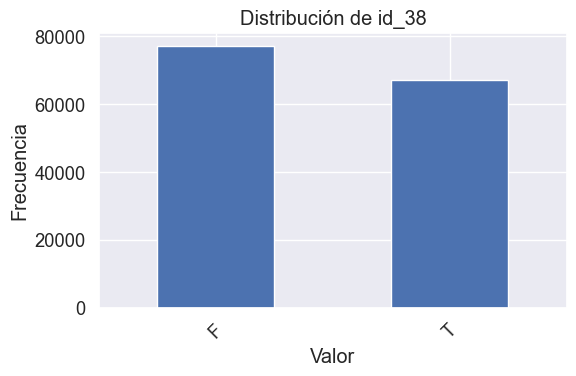


=== card6 ===
                   Valor  Frecuencia  Porcentaje
card6                                           
credit            credit       75268       52.19
debit              debit       68950       47.80
charge card  charge card          15        0.01


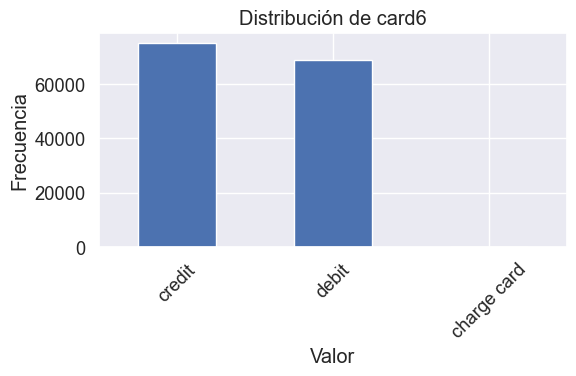

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Reafirmar columnas categóricas tipo object
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Total de filas
total = len(df)

# Recorrer cada columna categórica y mostrar valores únicos + porcentaje + gráfico
for col in categorical_cols:
    print(f"\n=== {col} ===")
    counts = df[col].value_counts(dropna=False)
    percentages = counts / total * 100
    summary = pd.DataFrame({
        'Valor': counts.index,
        'Frecuencia': counts.values,
        'Porcentaje': percentages.round(2)
    })
    print(summary)

    # Crear gráfico de barras
    plt.figure(figsize=(6, 4))
    counts.plot(kind='bar')
    plt.title(f'Distribución de {col}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [71]:
# Eliminar registros donde card6 es "charge card"
df = df[df['card6'] != 'charge card'].reset_index(drop=True)

print(f"Nuevo tamaño del dataset: {df.shape}")
print(df['card6'].value_counts(normalize=True) * 100)


Nuevo tamaño del dataset: (144218, 73)
card6
credit    52.190434
debit     47.809566
Name: proportion, dtype: float64


Se identificó que la categoría "charge card" en la variable `card6` tenía una frecuencia extremadamente baja (15 registros, 0.01%). Por esta razón, se optó por eliminar estos registros, ya que las categorías con muy baja representación pueden introducir ruido y no aportan valor estadístico al modelo.
Tras la limpieza, el dataset quedó con 144,218 registros, y se mantuvo una distribución balanceada entre "credit" (52.19%) y "debit" (47.81%).


In [72]:
info = pd.DataFrame({
    'Columna': df.columns,
    'Tipo de dato': df.dtypes,
    'Valores únicos': df.nunique()
})

# Ordenar por tipo de dato (opcional)
info = info.sort_values(by='Tipo de dato').reset_index(drop=True)

pd.set_option('display.max_rows', None)
print(info)


           Columna Tipo de dato  Valores únicos
0            id_01      float64              77
1             v261      float64              97
2             v250      float64              27
3             v238      float64              34
4             v229      float64             191
5             v227      float64              61
6             v226      float64             102
7             v267      float64            6231
8             v225      float64              83
9             v223      float64              42
10            v220      float64              43
11            v208      float64            3171
12            v185      float64              46
13            v184      float64              31
14            v177      float64             891
15            v224      float64             160
16            v175      float64              31
17            v271      float64            3165
18            v277      float64            4052
19            v338      float64         

Aunque el tipo de dato de la mayoría de las variables en el dataset es `float64`, esto no implica que todas ellas sean numéricas en su naturaleza. De acuerdo con la documentación del proveedor de datos, un número considerable de variables han sido codificadas desde categorías originales (por ejemplo, indicadores binarios, codificaciones de identidad, relaciones entre entidades o correspondencias de usuario). Este es el caso, por ejemplo, de las variables `M1` a `M9`, `id_12` a `id_38`, así como muchas de las variables `Vxxx`, cuyo significado exacto no es público.

Solamente algunas variables pueden asumirse con certeza como numéricas continuas: entre ellas se encuentran `TransactionAMT` (monto de la transacción), `TransactionDT` (tiempo relativo de la transacción), y algunas variables derivadas de diferencia temporal como `D1`, `D8` y `D9`. Estas variables reflejan cantidades medibles o intervalos reales y no surgen de procesos de codificación categórica.

Este aspecto constituye una limitación importante durante el análisis exploratorio, ya que impide aplicar ciertas técnicas estadísticas sin antes validar o reinterpretar el significado de las variables involucradas. Por tanto, en lo que sigue, los análisis serán aplicados de forma diferenciada, considerando esta ambigüedad en la interpretación de los datos codificados.

Veamos a continuación, el resto del análisis considerando la variable objetivo `isfraud`.

In [73]:
# Conteo y porcentaje de cada clase
conteo = df['isfraud'].value_counts()
porcentaje = df['isfraud'].value_counts(normalize=True) * 100

# Mostrar resumen en texto
print("Distribución de la variable 'isFraud':\n")
for clase in conteo.index:
    print(f"Clase {clase} -> {conteo[clase]:,} transacciones ({porcentaje[clase]:.2f}%)")


Distribución de la variable 'isFraud':

Clase 0.0 -> 132,900 transacciones (92.15%)
Clase 1.0 -> 11,318 transacciones (7.85%)


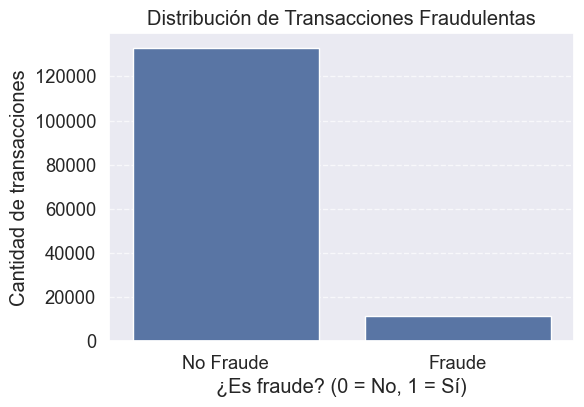

In [74]:
plt.figure(figsize=(6, 4))
sns.countplot(x='isfraud', data=df)
plt.title('Distribución de Transacciones Fraudulentas')
plt.xlabel('¿Es fraude? (0 = No, 1 = Sí)')
plt.ylabel('Cantidad de transacciones')
plt.xticks([0, 1], ['No Fraude', 'Fraude'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


La distribución de la variable `isFraud` revela un claro desbalance de clases: aproximadamente el 92% de las transacciones corresponden a casos no fraudulentos, mientras que solo el 8% son clasificadas como fraude. Esta desproporción puede afectar el desempeño de los modelos de clasificación, ya que las clases mayoritarias tienden a dominar las predicciones si no se aplican estrategias correctivas. Por esta razón, más adelante se implementarán técnicas de balanceo que permitirán mitigar este sesgo y mejorar la sensibilidad del modelo frente a la clase minoritaria.


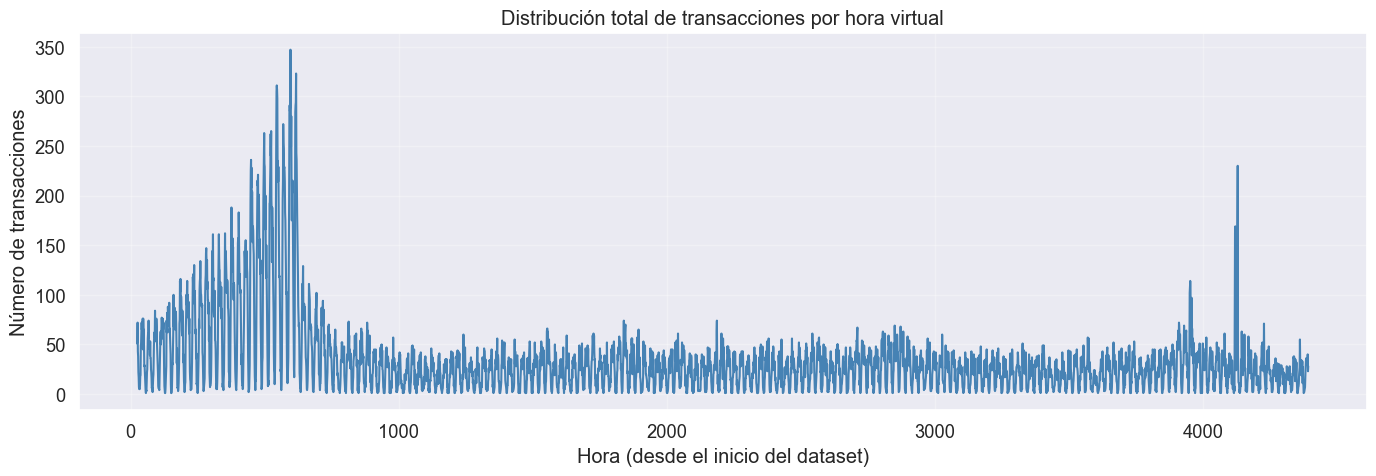

In [75]:
import matplotlib.pyplot as plt

# Asegurar que tengas la variable de hora
df['transaction_hour'] = (df['transactiondt'] // 3600).astype(int)

# Agrupar por hora y contar cantidad total de transacciones
counts = df['transaction_hour'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(counts.index, counts.values, color='steelblue')
plt.title("Distribución total de transacciones por hora virtual")
plt.xlabel("Hora (desde el inicio del dataset)")
plt.ylabel("Número de transacciones")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


La variable `TransactionDT` corresponde a un intervalo de tiempo medido a partir de una fecha y hora de referencia no especificada. Aunque no se detalla su unidad de medida oficial, su comportamiento creciente y el orden secuencial de los registros sugieren que podría representar una magnitud temporal como segundos o minutos. No obstante, dado que esta información no está explícitamente definida, no se asume ninguna escala temporal absoluta.

Para facilitar su análisis, se realizó una transformación sobre esta variable con el fin de obtener una versión más interpretable: la denominada "hora virtual". Esta transformación consistió en dividir cada valor de `TransactionDT` entre 3600, asumiendo operativamente que el dato representaba segundos, aunque sin pretender establecer correspondencia con una hora real. La finalidad de este procedimiento fue simplemente agrupar los registros en bloques temporales más comprensibles.

El gráfico generado a partir de esta nueva variable muestra la distribución total de transacciones a lo largo del tiempo registrado en el dataset. Se observa una marcada concentración de actividad durante las primeras horas virtuales, seguida de una fase de menor volumen y mayor estabilidad. Este patrón evidencia que la actividad transaccional no fue homogénea en el tiempo y refuerza la utilidad de esta transformación para identificar comportamientos relevantes o posibles anomalías temporales.


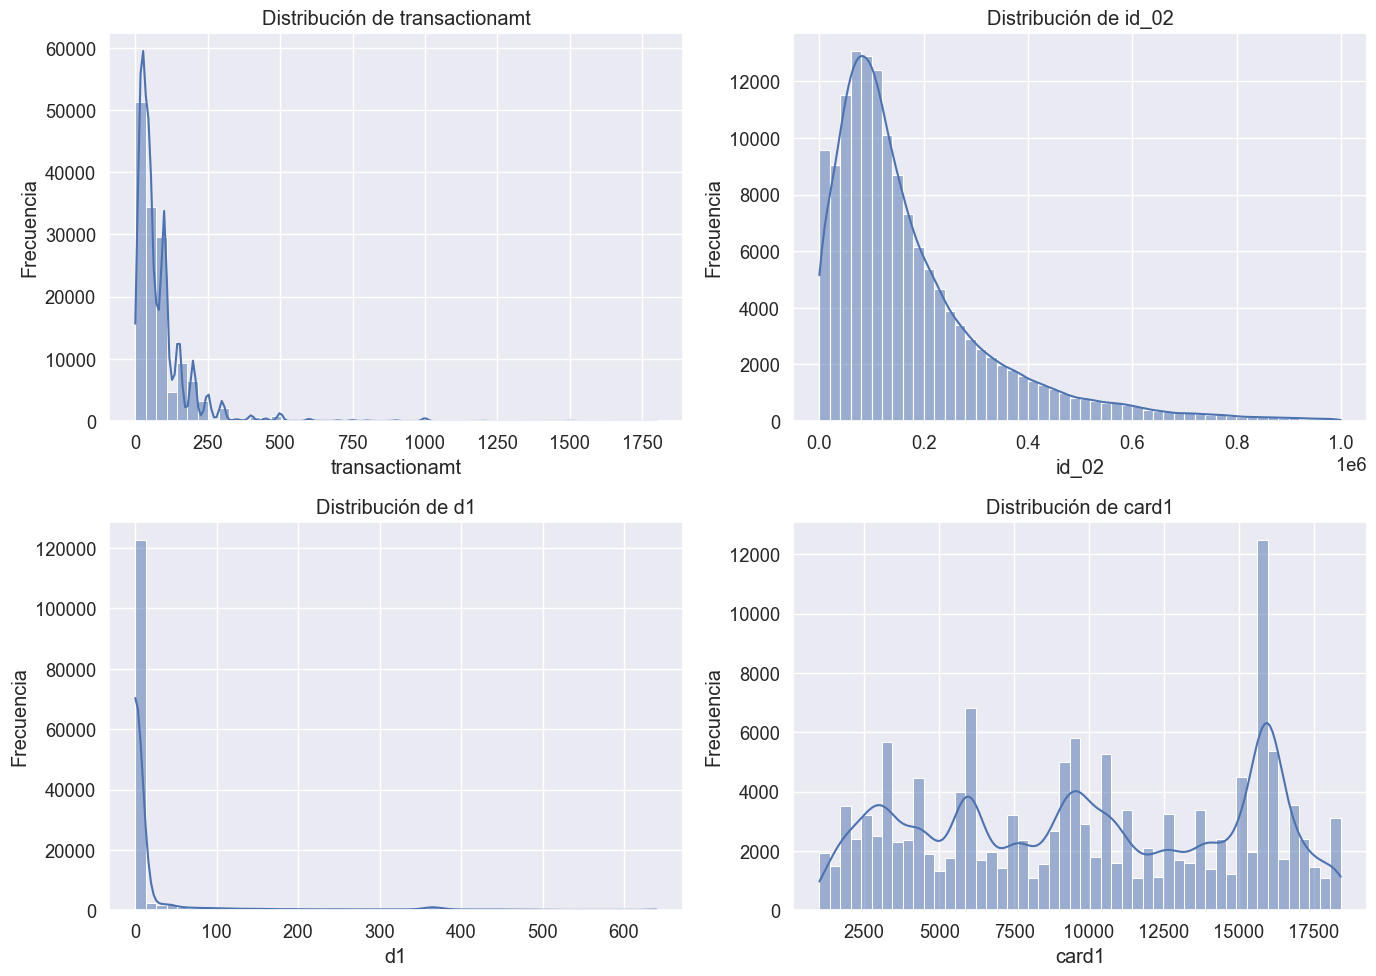

In [76]:
# Lista de variables para histograma
vars_hist = ['transactionamt', 'id_02', 'd1', 'card1']

# Graficar
plt.figure(figsize=(14, 10))

for i, col in enumerate(vars_hist):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=df, x=col, bins=50, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()

plt.show()


En esta sección se presentan los histogramas de cuatro variables con representación numérica: `transactionamt`, `id_02`, `d1` y `card1`. De acuerdo con la documentación, `transactionamt` corresponde al importe de la transacción en dólares estadounidenses, por lo que puede considerarse una variable numérica continua real. En este caso, el uso de un histograma es pertinente y revela una distribución fuertemente asimétrica hacia la derecha, con una alta concentración de montos bajos y algunos valores extremos, posiblemente correspondientes a pagos atípicos o devoluciones.

Por su parte, la variable `id_02` pertenece al conjunto `id_12` a `id_38`, las cuales corresponden a identificadores codificados relacionados con información digital del usuario o del dispositivo. Aunque su formato es numérico, su naturaleza es categórica codificada, por lo que un histograma tradicional pierde valor interpretativo directo. No obstante, observar su distribución permite detectar la existencia de valores dominantes o dispersión extrema, útil para identificar la necesidad de transformaciones o reducción de cardinalidad.

La variable `d1`, según la documentación, representa un intervalo de tiempo asociado a cada registro, posiblemente en días, aunque no se especifica con claridad respecto a qué evento se mide. Su formato es numérico y discreto, con una concentración marcada en valores bajos, lo que sugiere que muchas observaciones presentan un tiempo corto respecto al evento de referencia. El histograma correspondiente permite visualizar esta acumulación y observar la proporción de casos que presentan intervalos prolongados.

Finalmente, `card1` corresponde a un identificador vinculado a la tarjeta del usuario (posiblemente un hash o codificación del emisor o tipo de tarjeta). Su apariencia numérica no refleja una cantidad medible, sino una codificación categórica de alta cardinalidad. Por lo tanto, aunque se grafica como histograma, su interpretación debe limitarse a la detección de frecuencias relativas por categoría codificada, y no como variable continua. En este tipo de variables, otros enfoques como el conteo de valores únicos o su relación directa con la variable objetivo suelen ser más adecuados.


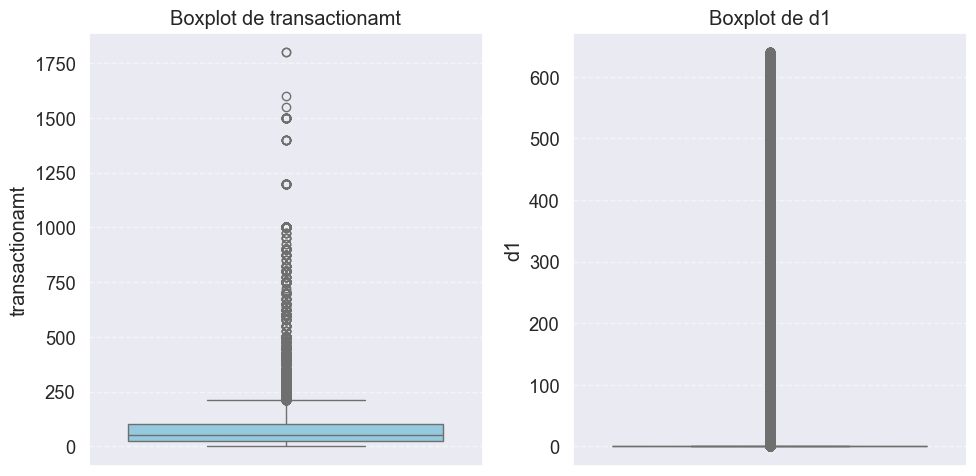

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables que sí tienen sentido en boxplot univariado
vars_box = ['transactionamt', 'd1']

# Crear figura
plt.figure(figsize=(10, 5))

# Boxplots individuales
for i, col in enumerate(vars_box):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(data=df, y=col, color='skyblue')
    plt.title(f'Boxplot de {col}')
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



In [78]:
# Resumen estadístico de transactionamt y d1
print("Resumen estadístico de 'transactionamt'\n")
print(df[['transactionamt']].describe())


Resumen estadístico de 'transactionamt'

       transactionamt
count   144218.000000
mean        83.557032
std         99.853824
min          0.251000
25%         25.453000
50%         50.000000
75%        100.000000
max       1800.000000


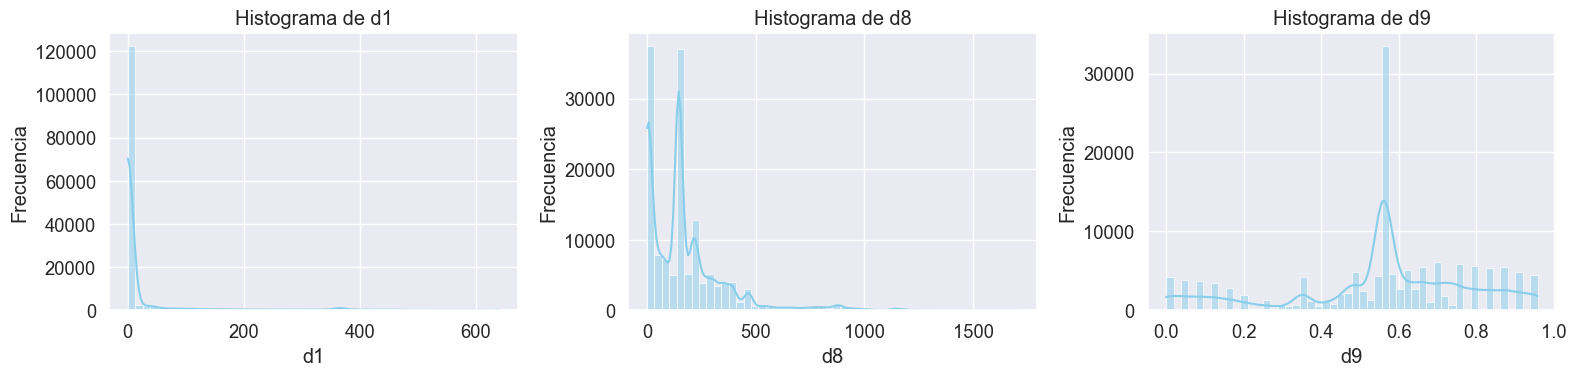

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Detectar columnas D1 a D15 válidas 
d_cols = [col for col in df.columns if col.lower().startswith('d') and col[1:].isdigit()]
d_validas = [col for col in d_cols if df[col].notnull().mean() > 0.8 and df[col].nunique() > 1]

# Graficar histogramas de las variables D seleccionadas
plt.figure(figsize=(16, 4 * ((len(d_validas) + 2) // 3)))

for i, col in enumerate(d_validas):
    plt.subplot((len(d_validas) + 2) // 3, 3, i + 1)
    sns.histplot(df[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [80]:
# Seleccionar todas las columnas que comienzan con 'd' seguido de número
d_cols = [col for col in df.columns if col.lower().startswith('d') and col[1:].isdigit()]

# Mostrar resumen estadístico
print("Resumen estadístico de las variables D1 a D15:\n")
print(df[d_cols].describe())


Resumen estadístico de las variables D1 a D15:

                  d1             d8             d9
count  144218.000000  144218.000000  144218.000000
mean       29.333115     172.608319       0.553668
std        95.154985     182.364964       0.240275
min         0.000000       0.000000       0.000000
25%         0.000000      29.083332       0.483333
50%         0.000000     146.058108       0.561057
75%         0.000000     221.791672       0.708333
max       640.000000    1707.791626       0.958333


Las variables `d1`, `d8` y `d9` forman parte del conjunto `D1` a `D15`, asociadas a intervalos de tiempo entre eventos. Todas fueron incluidas en el modelo sin transformación previa, ya que su formato numérico era compatible y no requería codificación adicional.

En el caso de `d1`, se observa una fuerte concentración en valores bajos, con más del 75% de los registros en cero y presencia de valores atípicos. `d8` presenta mayor dispersión, con una mediana intermedia y valores máximos elevados. Por su parte, `d9` tiene un rango acotado entre 0 y 1, y aunque su significado no es completamente claro, su comportamiento discreto sugiere que podría representar proporciones o una codificación binaria. En todos los casos, su inclusión se justificó por su carácter numérico y por conservar variabilidad suficiente.


In [81]:
# Usamos la columna original o la winsorizada
data = df['transactionamt']

result = anderson(data)

print("=== Anderson-Darling Test ===")
print(f"Estadístico A: {result.statistic:.4f}")
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    print(f"Nivel de significancia: {sl:.1f}% | Valor crítico: {cv:.4f}")
    
if result.statistic > result.critical_values[2]:  
    print("\nConclusión: Rechazamos H0 → No es normal")
else:
    print("\nConclusión: No se rechaza H0 → Podría ser normal")


=== Anderson-Darling Test ===
Estadístico A: 11934.4809
Nivel de significancia: 15.0% | Valor crítico: 0.5760
Nivel de significancia: 10.0% | Valor crítico: 0.6560
Nivel de significancia: 5.0% | Valor crítico: 0.7870
Nivel de significancia: 2.5% | Valor crítico: 0.9180
Nivel de significancia: 1.0% | Valor crítico: 1.0920

Conclusión: Rechazamos H0 → No es normal


In [82]:
import numpy as np

# Transformación logarítmica segura (log(1 + x)) para evitar log(0)
df['transactionamt_log'] = np.log1p(df['transactionamt'])


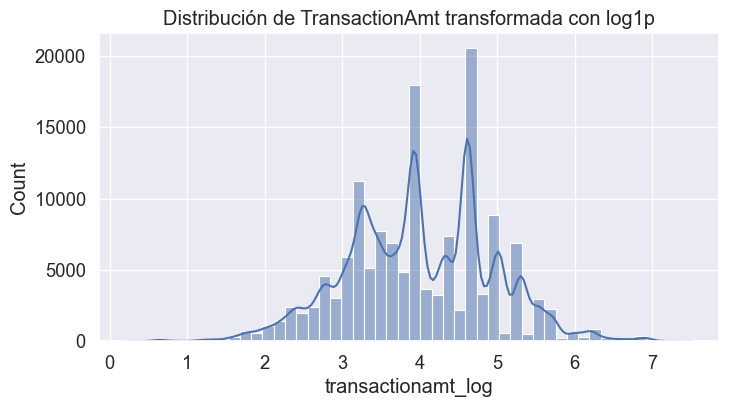

In [83]:

plt.figure(figsize=(8, 4))
sns.histplot(df['transactionamt_log'], bins=50, kde=True)
plt.title("Distribución de TransactionAmt transformada con log1p")
plt.show()


In [84]:
# Prueba sobre la variable transformada
result_log = anderson(df['transactionamt_log'])

print("=== Anderson-Darling sobre log1p(TransactionAmt) ===")
print(f"Estadístico A: {result_log.statistic:.4f}")
for i in range(len(result_log.critical_values)):
    sl, cv = result_log.significance_level[i], result_log.critical_values[i]
    print(f"Nivel de significancia: {sl:.1f}% | Valor crítico: {cv:.4f}")
    
if result_log.statistic > result_log.critical_values[2]:  # 5%
    print("\nConclusión: Rechazamos H0 → no es normal")
else:
    print("\nConclusión: No se rechaza H0 → Podría ser normal")


=== Anderson-Darling sobre log1p(TransactionAmt) ===
Estadístico A: 424.5350
Nivel de significancia: 15.0% | Valor crítico: 0.5760
Nivel de significancia: 10.0% | Valor crítico: 0.6560
Nivel de significancia: 5.0% | Valor crítico: 0.7870
Nivel de significancia: 2.5% | Valor crítico: 0.9180
Nivel de significancia: 1.0% | Valor crítico: 1.0920

Conclusión: Rechazamos H0 → no es normal


La variable `transactionamt`, que representa el valor monetario de cada transacción en dólares estadounidenses, presentó desde el inicio una distribución altamente asimétrica, con la mayoría de los valores concentrados en montos bajos y una cola extendida de transacciones con valores significativamente más altos. Este comportamiento fue confirmado tanto visualmente como mediante el test de Anderson-Darling, que permitió rechazar la hipótesis nula de normalidad.

Dado que esta variable es continua, estrictamente positiva y sensible a valores extremos, se consideró apropiado aplicar una transformación logarítmica. Para ello, se utilizó la función `log1p`, que implementa la transformación `log(1 + x)`, lo cual permite estabilizar la varianza sin generar errores al procesar valores cercanos a cero. La variable transformada (`transactionamt_log`) mostró una estructura más simétrica y comprimió los valores atípicos, haciendo más robusta su participación en modelos que pueden verse afectados por escalas desproporcionadas. En consecuencia, fue esta versión transformada (`transactionamt_log`) la que se incorporó al conjunto de entrenamiento. Se descartó el uso de la variable original ya que su distribución severamente sesgada podía inducir sesgos en algoritmos lineales o afectar el rendimiento de modelos que asumen cierta homogeneidad en la escala de los predictores.


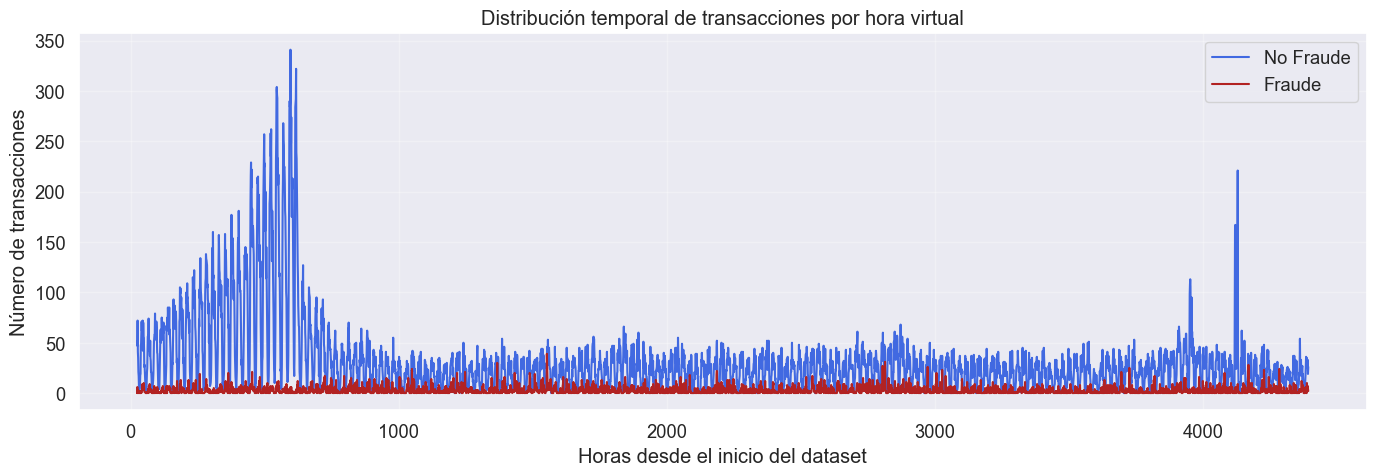

In [85]:
import matplotlib.pyplot as plt

# Paso 1: crear la columna de hora virtual
df['transaction_hour'] = (df['transactiondt'] // 3600).astype(int)

# Paso 2: agrupar por hora y clase
counts = df.groupby(['transaction_hour', 'isfraud']).size().unstack(fill_value=0)

# Paso 3: graficar
plt.figure(figsize=(14, 5))
plt.plot(counts.index, counts[0], label='No Fraude', color='royalblue')
plt.plot(counts.index, counts[1], label='Fraude', color='firebrick')
plt.title("Distribución temporal de transacciones por hora virtual")
plt.xlabel("Horas desde el inicio del dataset")
plt.ylabel("Número de transacciones")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Con base en la variable `TransactionDT` previamente transformada a una escala de "hora virtual", se generó una nueva visualización que incorpora la variable objetivo `isfraud`. Esta partición permite comparar directamente el comportamiento temporal de las transacciones legítimas y fraudulentas a lo largo del tiempo registrado en el dataset.

El gráfico evidencia que, aunque ambas clases comparten la misma tendencia general de concentración en las primeras horas virtuales, las transacciones fraudulentas son considerablemente menos frecuentes. Esta superposición permite detectar diferencias de densidad y posibles patrones temporales particulares asociados al fraude. La representación diferenciada refuerza la utilidad de `transaction_hour` como variable explicativa en modelos de clasificación, al capturar dinámicas relevantes en la ocurrencia del fraude en función del tiempo.


In [86]:
print(df.columns.tolist())


['id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_10', 'id_19', 'id_20', 'isfraud', 'transactiondt', 'transactionamt', 'card1', 'card2', 'addr1', 'c3', 'c14', 'd1', 'd8', 'd9', 'v98', 'v124', 'v135', 'v138', 'v140', 'v141', 'v142', 'v146', 'v149', 'v152', 'v159', 'v160', 'v161', 'v162', 'v164', 'v169', 'v172', 'v173', 'v174', 'v175', 'v177', 'v184', 'v185', 'v208', 'v220', 'v223', 'v224', 'v225', 'v226', 'v227', 'v229', 'v238', 'v250', 'v261', 'v267', 'v271', 'v274', 'v277', 'v281', 'v282', 'v286', 'v287', 'v289', 'v291', 'v296', 'v301', 'v311', 'v313', 'v314', 'v326', 'v335', 'v338', 'id_38', 'card6', 'transaction_hour', 'transactionamt_log']


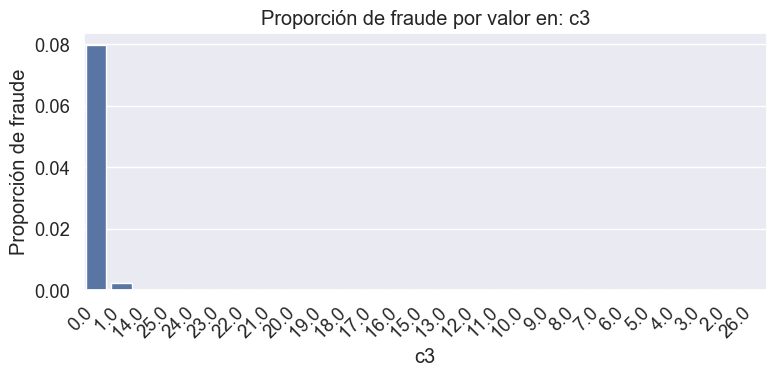

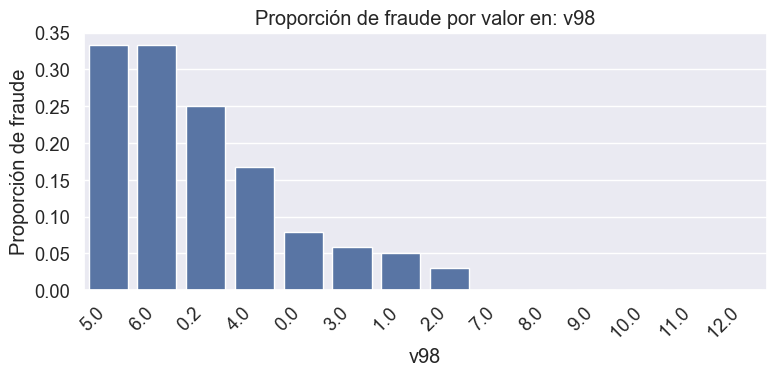

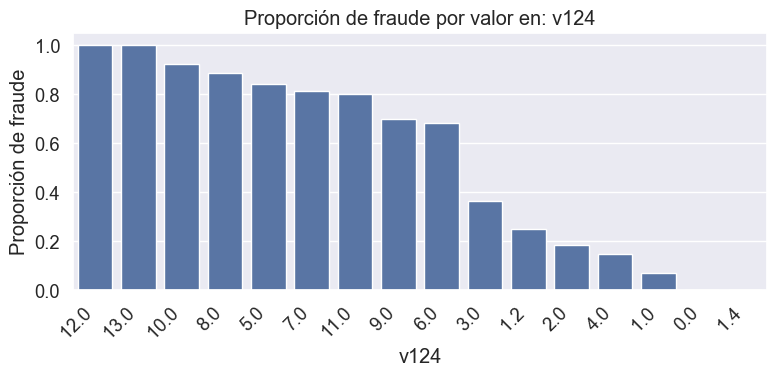

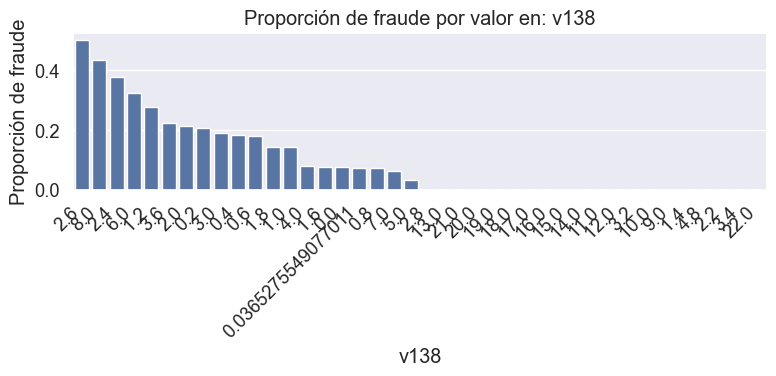

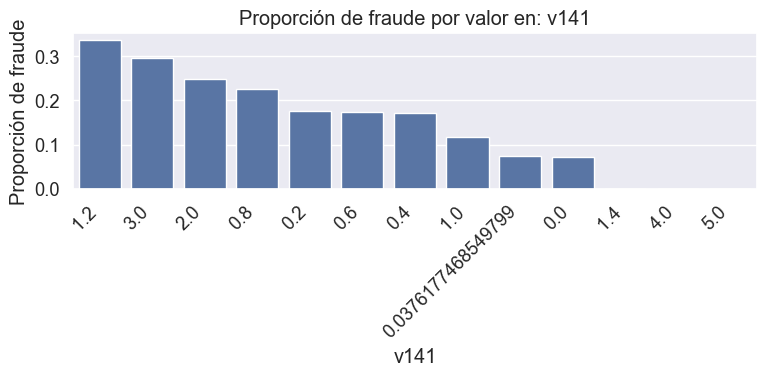

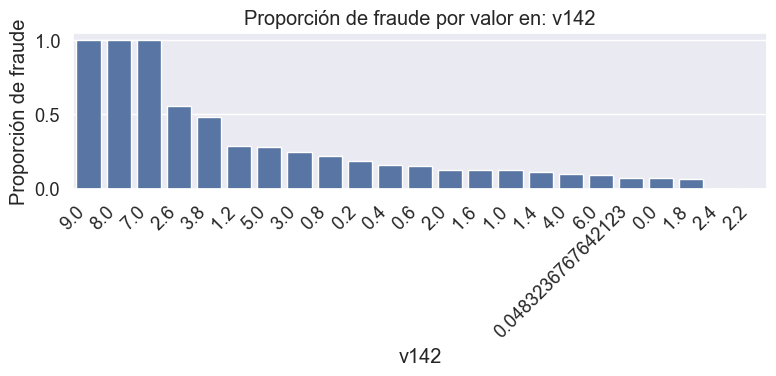

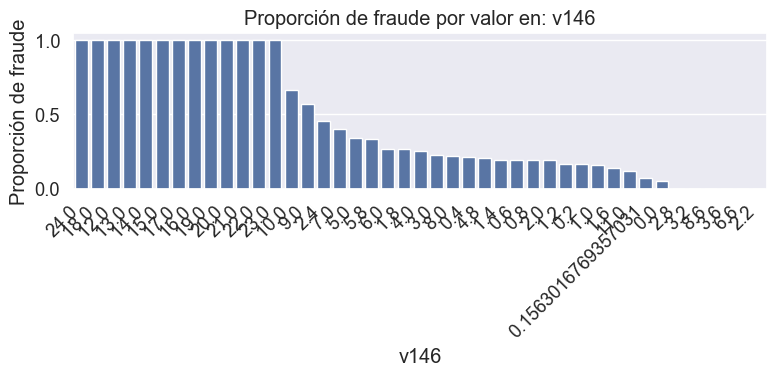

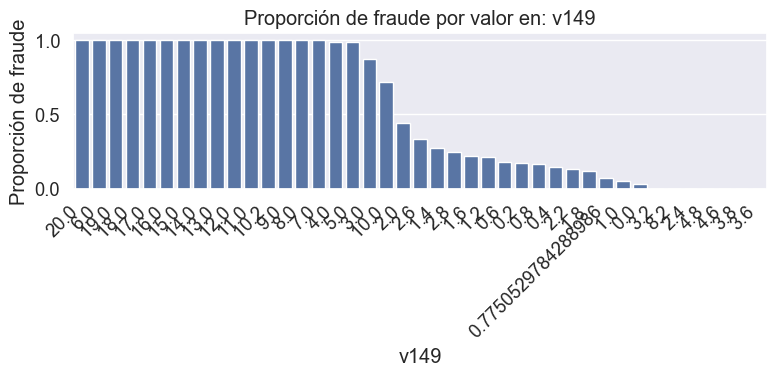

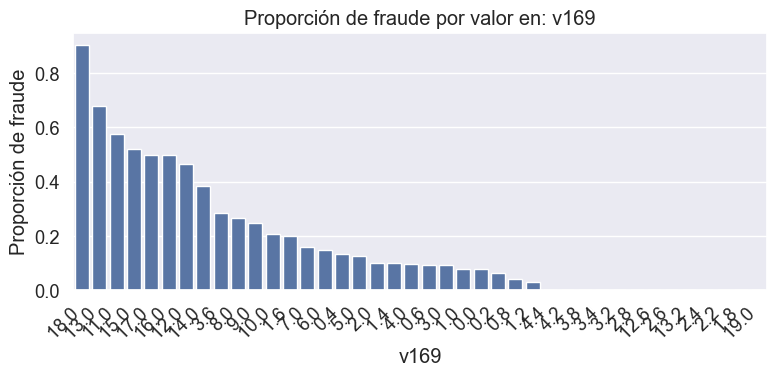

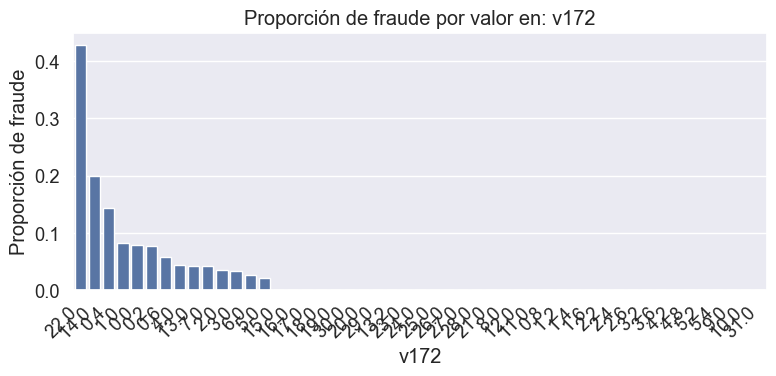

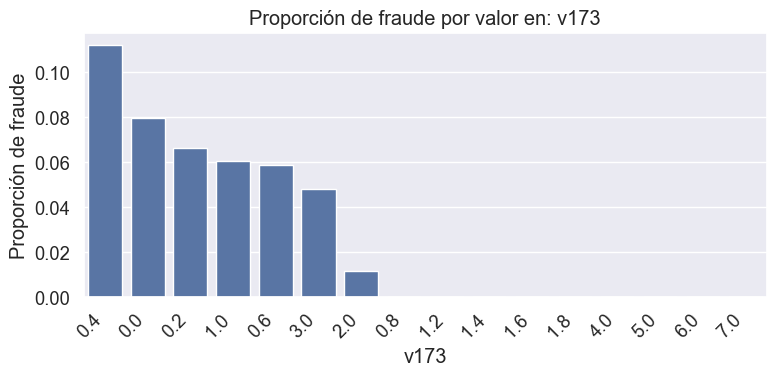

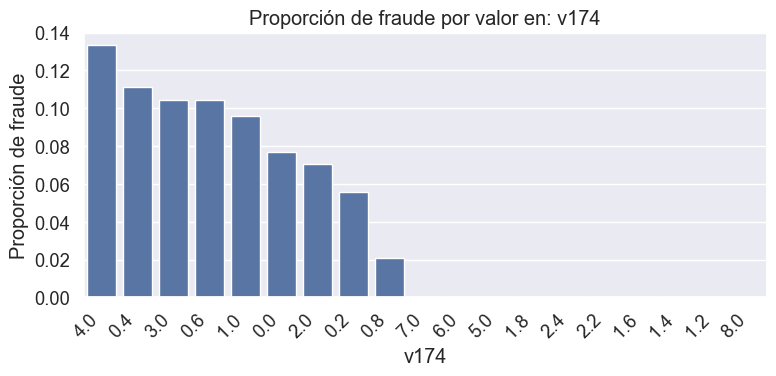

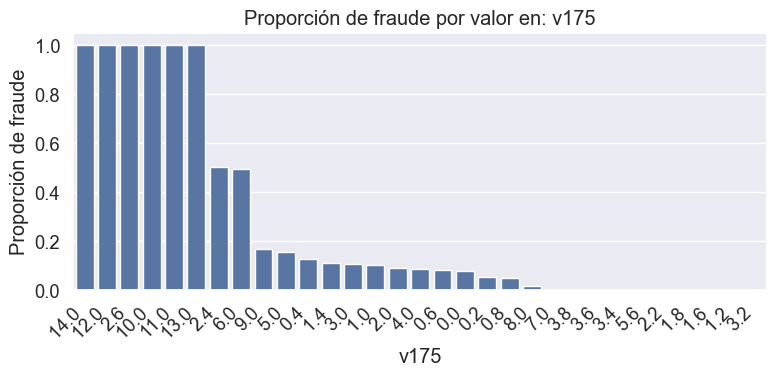

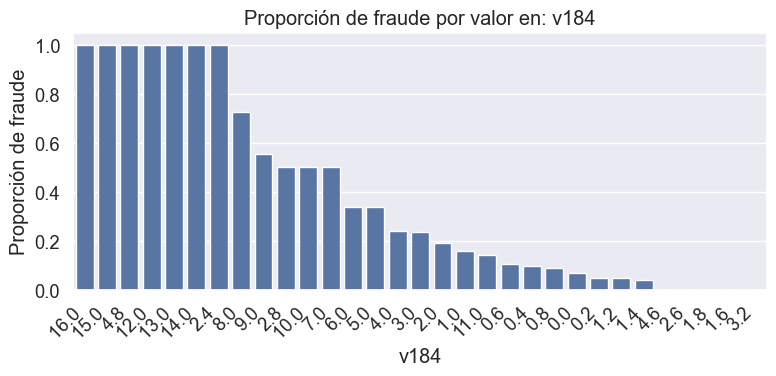

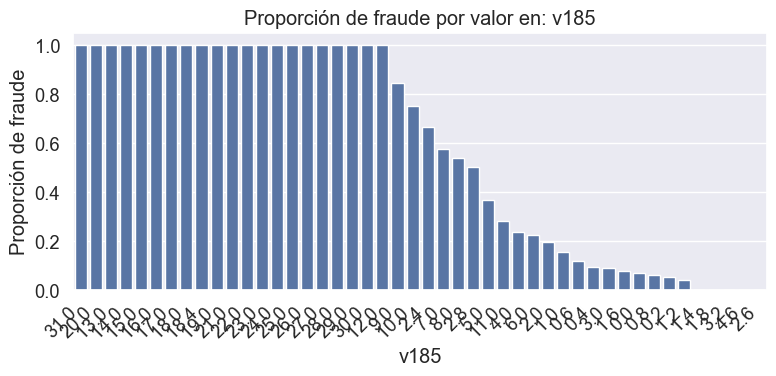

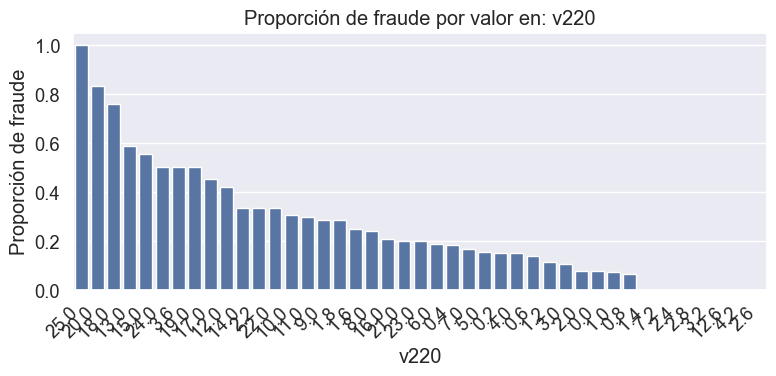

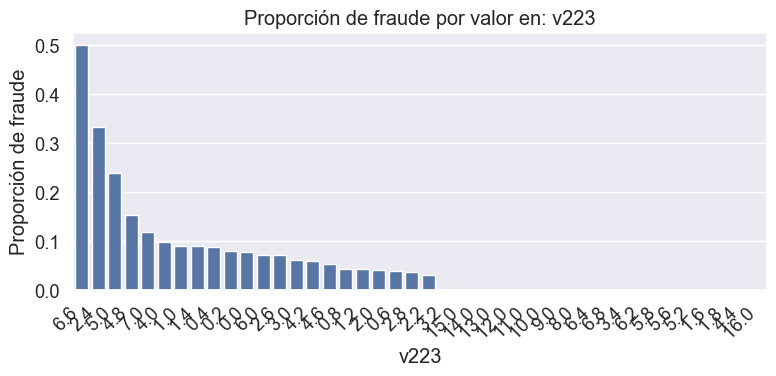

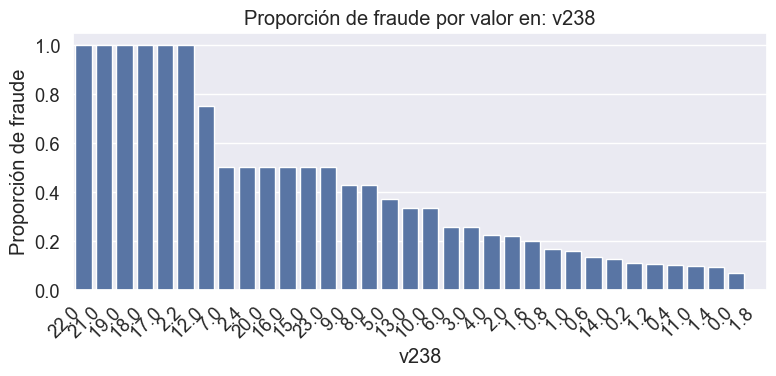

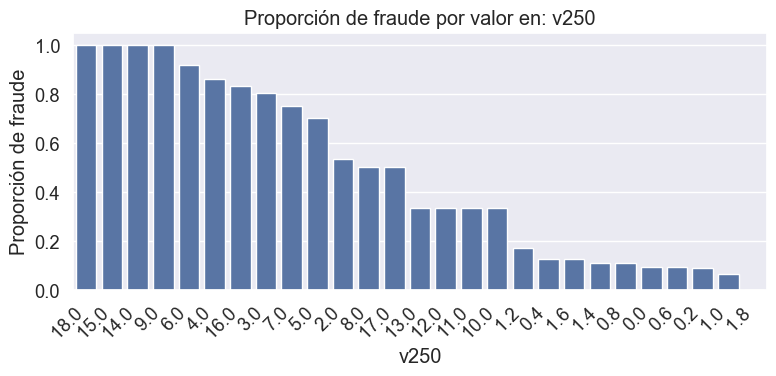

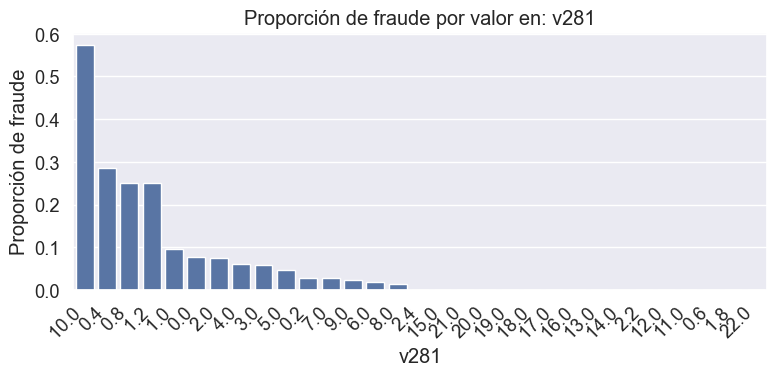

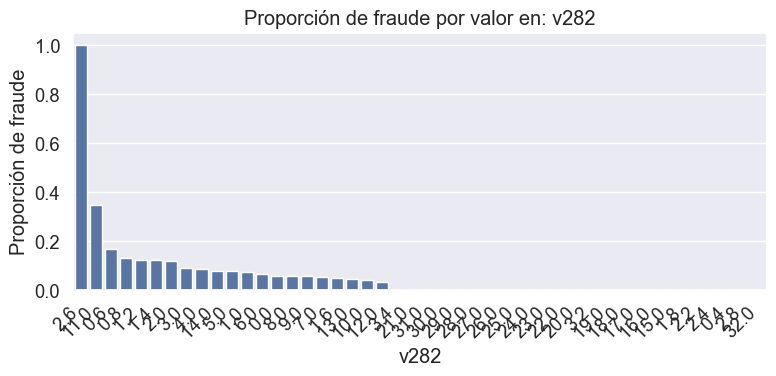

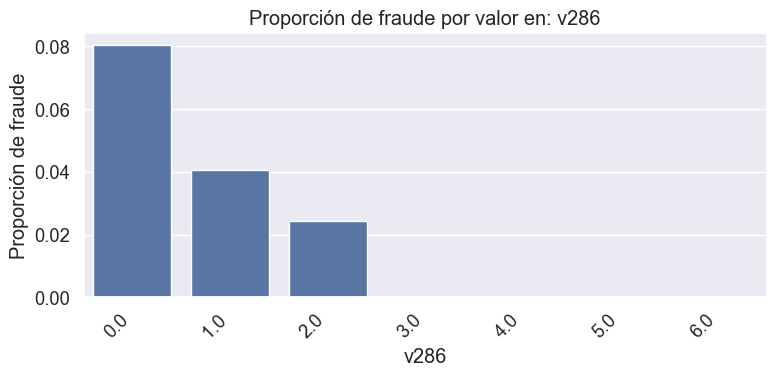

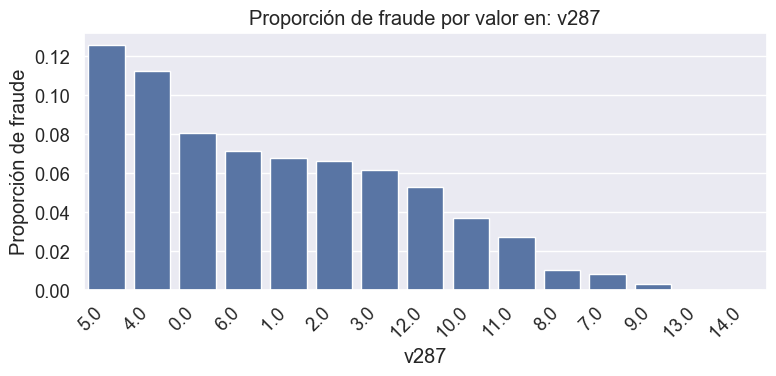

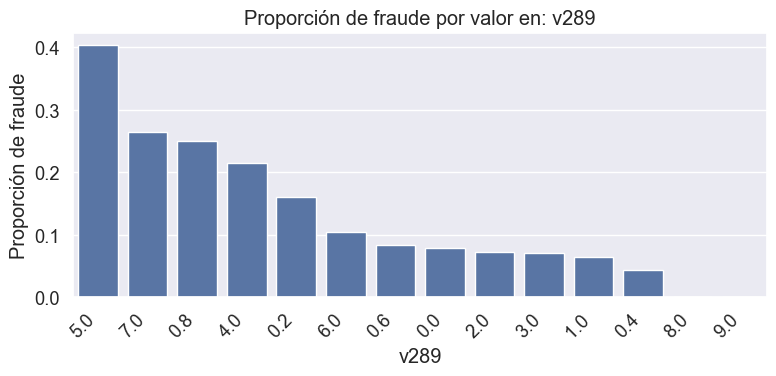

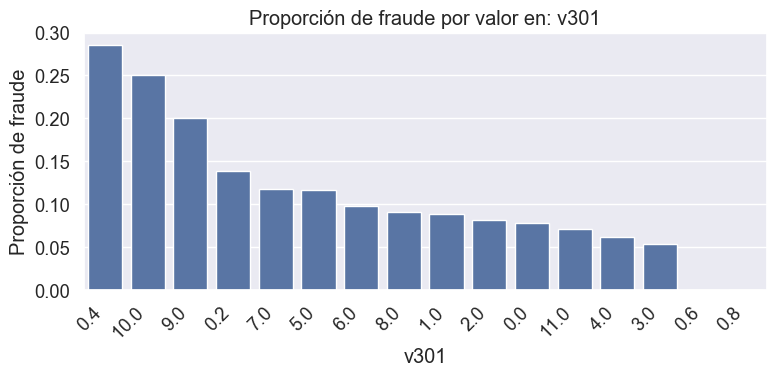

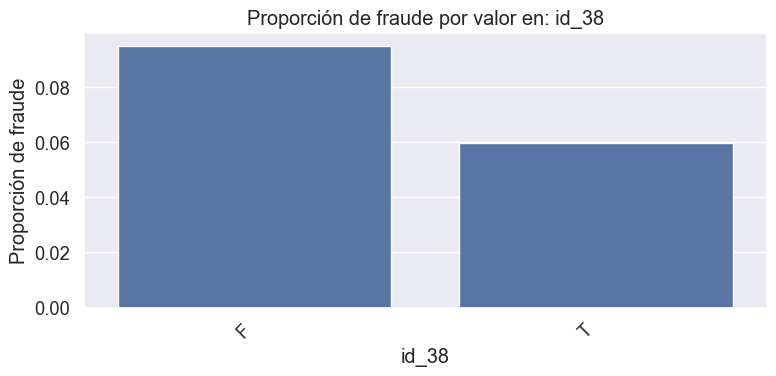

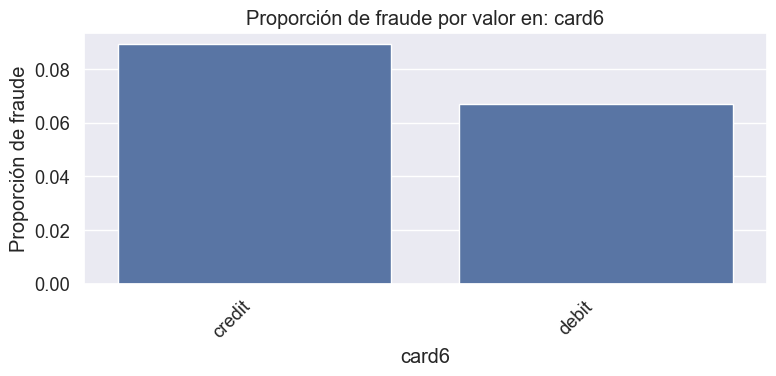

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista completa de tus variables
columnas = ['id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_10', 'id_19', 'id_20', 'isfraud',
            'transactiondt', 'transactionamt', 'card1', 'card2', 'addr1', 'c3', 'c14', 'd1', 'd8', 'd9',
            'v98', 'v124', 'v135', 'v138', 'v140', 'v141', 'v142', 'v146', 'v149', 'v152', 'v159',
            'v160', 'v161', 'v162', 'v164', 'v169', 'v172', 'v173', 'v174', 'v175', 'v177', 'v184',
            'v185', 'v208', 'v220', 'v223', 'v224', 'v225', 'v226', 'v227', 'v229', 'v238', 'v250',
            'v261', 'v267', 'v271', 'v274', 'v277', 'v281', 'v282', 'v286', 'v287', 'v289', 'v291',
            'v296', 'v301', 'v311', 'v313', 'v314', 'v326', 'v335', 'v338', 'id_38', 'card6', 'transaction_hour']

# Graficar proporciones de fraude para columnas con baja cardinalidad
for col in columnas:
    if df[col].nunique() <= 50 and col != 'isfraud':
        proporciones = df.groupby(col)['isfraud'].mean().sort_values(ascending=False)

        plt.figure(figsize=(8, 4))
        sns.barplot(x=proporciones.index.astype(str), y=proporciones.values)
        plt.title(f"Proporción de fraude por valor en: {col}")
        plt.xlabel(col)
        plt.ylabel("Proporción de fraude")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()



A partir de las gráficas generadas que representan la proporción de fraude por valor específico en distintas variables con baja cardinalidad, se pueden observar patrones interesantes de asociación entre ciertos valores y la variable objetivo `isfraud`. La mayoría de las variables analizadas provienen del grupo codificado como `vXXX`, correspondiente a funciones de la plataforma Vesta relacionadas con clasificaciones y relaciones entre entidades. Por ejemplo, variables como `v124`, `v142`, `v146` o `v238` muestran una concentración significativa de fraude en un subconjunto reducido de valores, con proporciones que incluso alcanzan el 100% para ciertos casos, lo que sugiere que pueden tener una alta capacidad discriminativa si se utilizan adecuadamente en el modelo.

Este análisis resulta útil para detectar valores que podrían estar correlacionados con transacciones fraudulentas, especialmente en contextos donde la variable original ha sido codificada y no se tiene una interpretación directa. A pesar de ello, hay que tener en cuenta que no todas las variables mostraron un patrón claro; algunas como `c3` o `v286` presentan una distribución mucho más homogénea o irrelevante. 

Estos hallazgos respaldan la necesidad de tratar estas variables con criterios adicionales (como su relevancia estadística o mediante técnicas automáticas de selección) en lugar de descartar a priori por su naturaleza codificada. En definitiva, este enfoque permite rescatar señales útiles incluso en variables no interpretables directamente.


#### **Transformación final**

In [90]:

# Eliminar columna original si ya no se usará
#df = df.drop(columns=['transactionamt'])

# Renombrar la transformada para mantener consistencia
#df.rename(columns={'transactionamt_log': 'transactionamt'}, inplace=True)

# Guardar
#df.to_csv("fraude_final.csv", index=False)

#print("Dataset guardado como 'fraude_final.csv' con la versión logarítmica.")
